In [286]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pdpbox import pdp
import xgboost as xgb
import sklearn
import partial_dependence

# Exploratory analysis

In [287]:
df = pd.read_csv('conversion_data.csv')

In [288]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [289]:
df.describe()

# Note the age has max of 123, according to wikipedia that's impossible

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


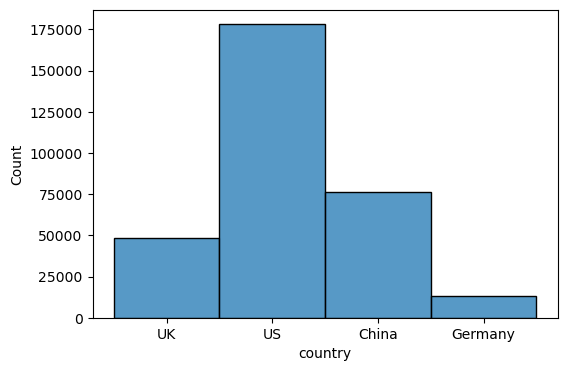

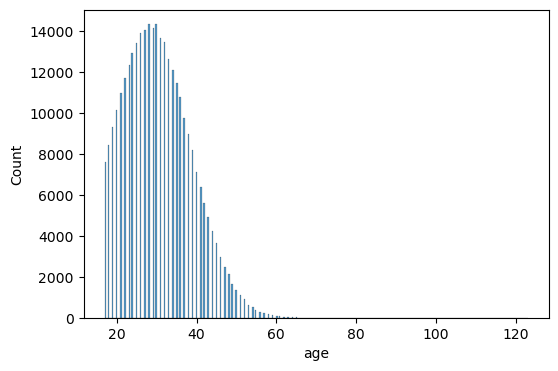

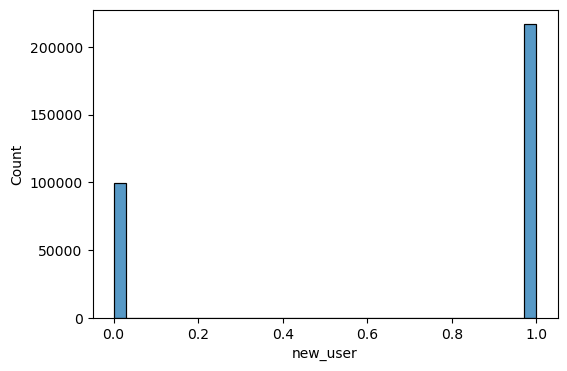

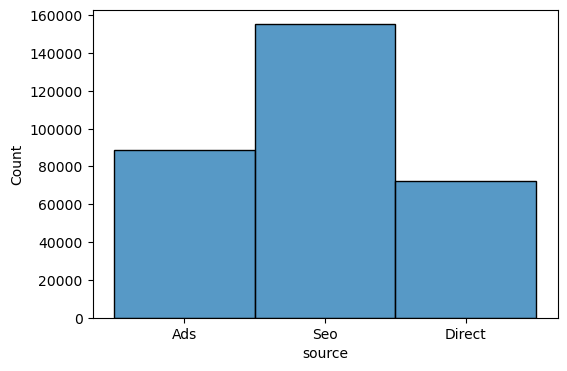

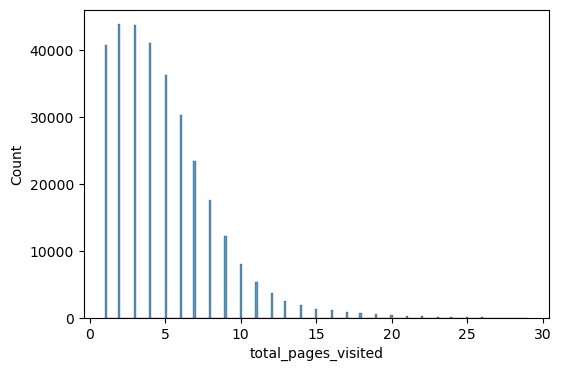

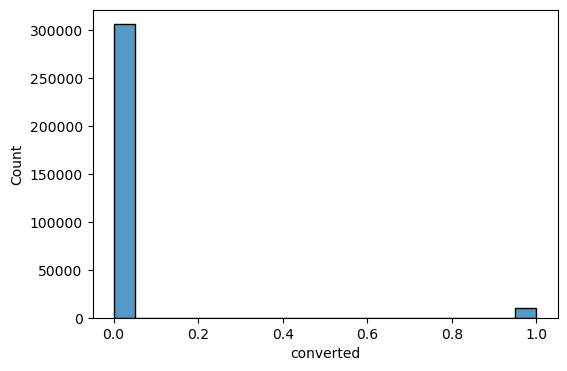

In [290]:
for col in df.columns:
    plt.figure()
    sns.histplot(df[col])
    
# plot distribution    
# Note, Though total_pages_visited has max values that are
# several SD away from the mean, the distribution shows that
# it is unlikely outliers

In [291]:
df.sort_values(by='age').tail(5)

# Remove the top 2

,country,age,new_user,source,total_pages_visited,converted
154217,US,73,1,Seo,5,0
192644,US,77,0,Direct,4,0
265167,US,79,1,Direct,1,0
295581,UK,111,0,Ads,10,1
90928,Germany,123,0,Seo,15,1


In [292]:
# Remove outliers
df = df[df.age <= 100]

In [293]:
df.dtypes

country                object
age                     int64
new_user                int64
source                 object
total_pages_visited     int64
converted               int64
dtype: object

<AxesSubplot:xlabel='country', ylabel='convert_ratio'>

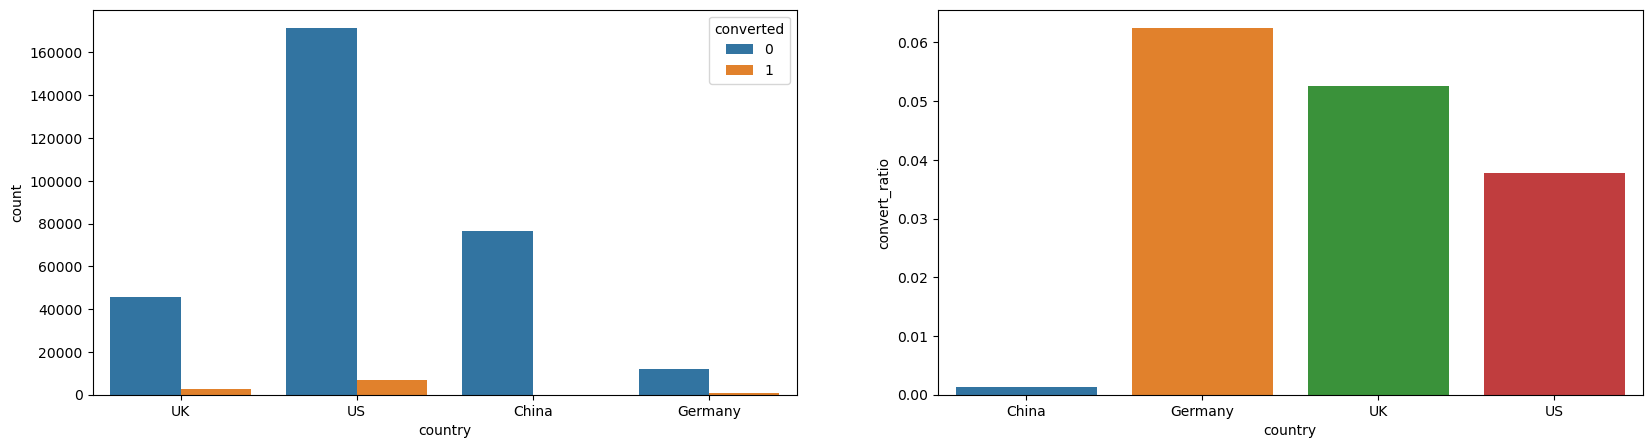

In [294]:
# Country
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
sns.countplot(data=df, x="country", hue="converted", ax = ax[0])
sns.barplot(data=df.groupby('country')['converted'].agg(convert_ratio = 'mean').reset_index(), 
              x="country", y="convert_ratio", ax = ax[1])

In [295]:
# We have several notable findings here
# 1. China has a lot of traffic, but the conversion is bad, worthy finding out why
# 2. Germany has a high conversion rate, perhaps we should keep digging into this, eg, why? What can we learn
# and, apply to other silos, like US? 

<AxesSubplot:xlabel='age_group', ylabel='convert_ratio'>

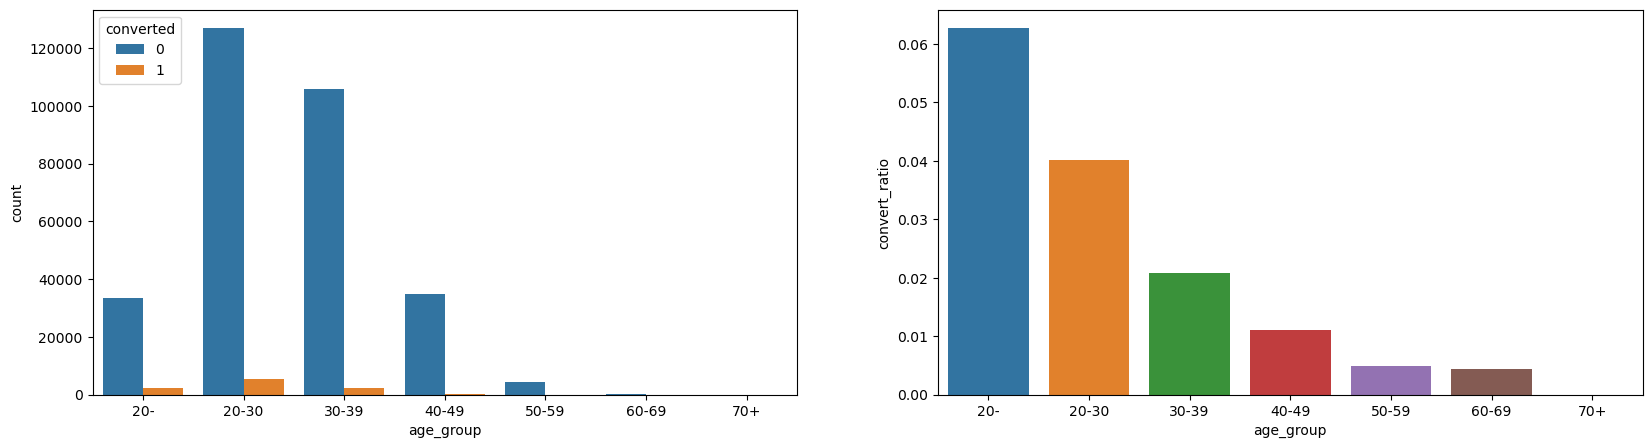

In [296]:
# Age
bins = [0,20, 30, 40, 50, 60, 70, 100]
labels = ['20-','20-30', '30-39', '40-49', '50-59', '60-69', '70+']
df['age_group'] = pd.cut(df.age, bins, labels = labels)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
sns.countplot(data=df, x="age_group", hue="converted", ax = ax[0])
sns.barplot(data=df.groupby('age_group')['converted'].agg(convert_ratio = 'mean').reset_index(), 
              x="age_group", y="convert_ratio", ax = ax[1])


In [297]:
# younger user are more likely to be converted
# Why? Should we better adapt to the old. If yes, may be add features like enlarged text, etc,.?
# We are converting really well for the young, might worth the effort of introducing more traffic there with
# campaigns targeting the young?

<AxesSubplot:xlabel='new_user', ylabel='convert_ratio'>

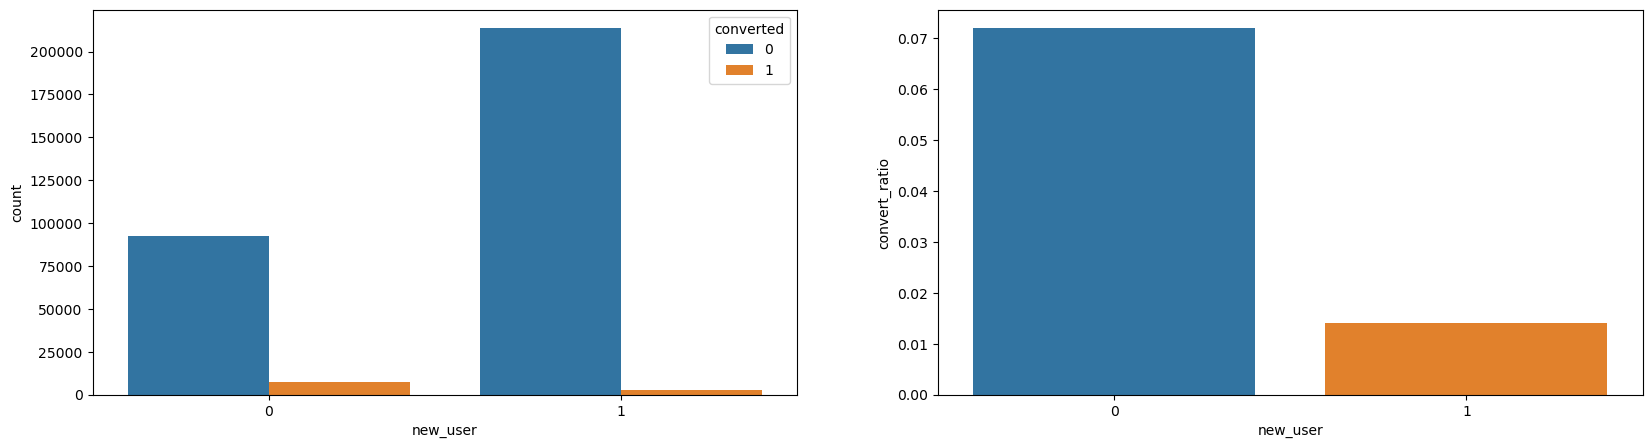

In [298]:
# New user 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
sns.countplot(data=df, x="new_user", hue="converted", ax = ax[0])
sns.barplot(data=df.groupby('new_user')['converted'].agg(convert_ratio = 'mean').reset_index(), 
              x="new_user", y="convert_ratio", ax = ax[1])


In [299]:
# this is sort of intuitive that the two var are coorelated.


<AxesSubplot:xlabel='source', ylabel='convert_ratio'>

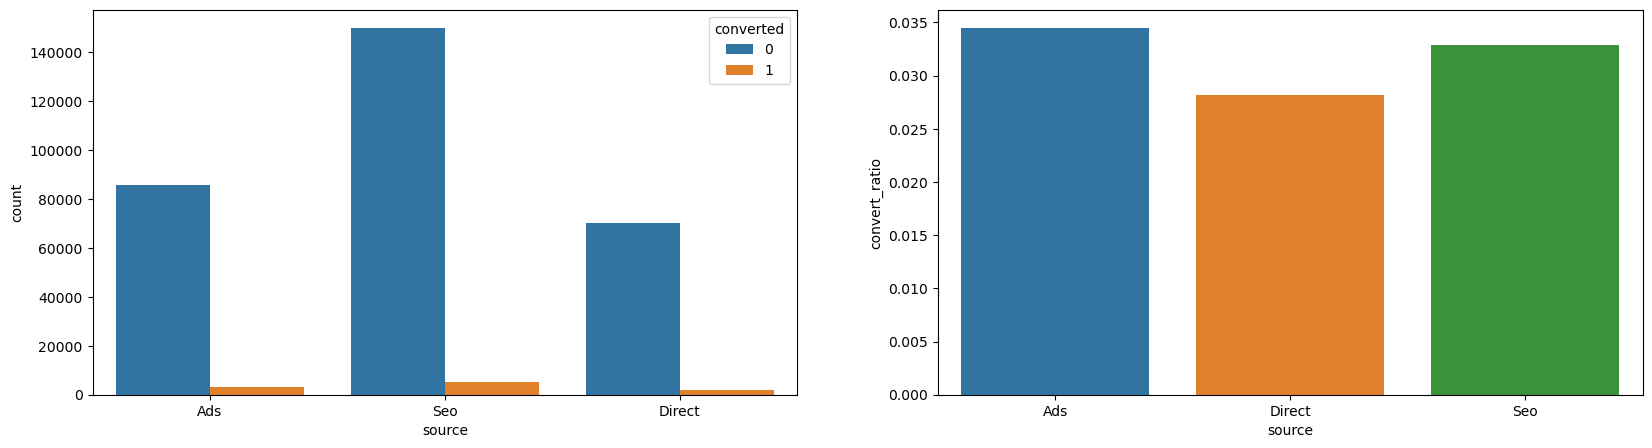

In [300]:
# source
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
sns.countplot(data=df, x="source", hue="converted", ax = ax[0])
sns.barplot(data=df.groupby('source')['converted'].agg(convert_ratio = 'mean').reset_index(), 
              x="source", y="convert_ratio", ax = ax[1])


In [301]:
# A minor unintuitive finding, direct search should come with higher intent, however,
# here the conversion for it is lower than the other 2 lower-intent visit. 
# What is the problem? Seems worth digging into it.

<AxesSubplot:xlabel='source', ylabel='convert_ratio'>

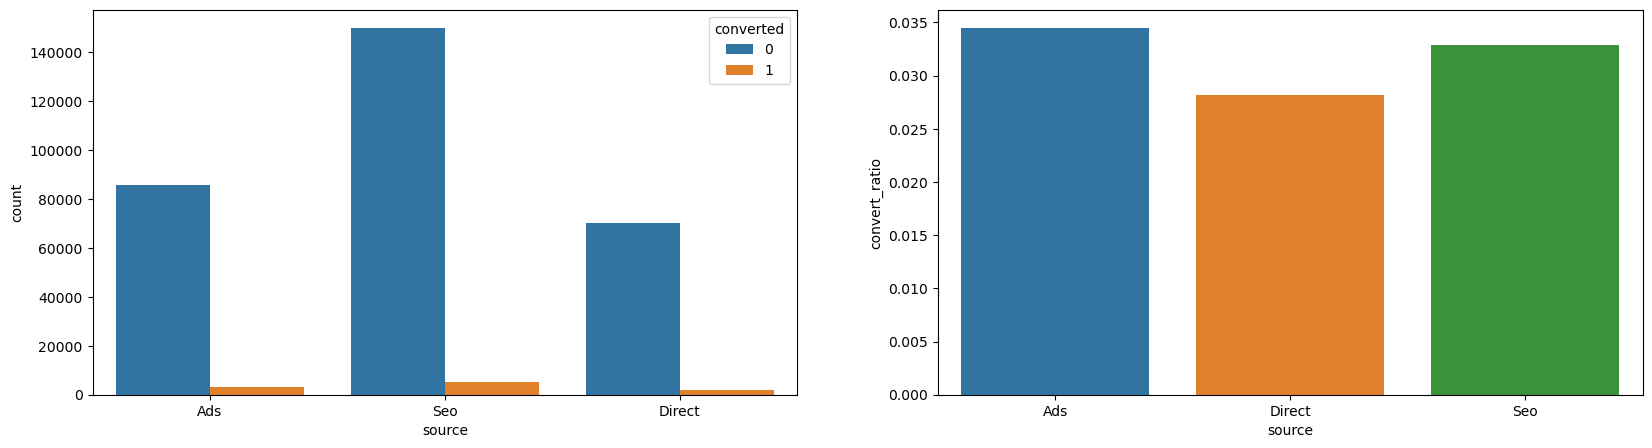

In [302]:
# source
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
sns.countplot(data=df, x="source", hue="converted", ax = ax[0])
sns.barplot(data=df.groupby('source')['converted'].agg(convert_ratio = 'mean').reset_index(), 
              x="source", y="convert_ratio", ax = ax[1])


<AxesSubplot:xlabel='total_pages_visited_group', ylabel='convert_ratio'>

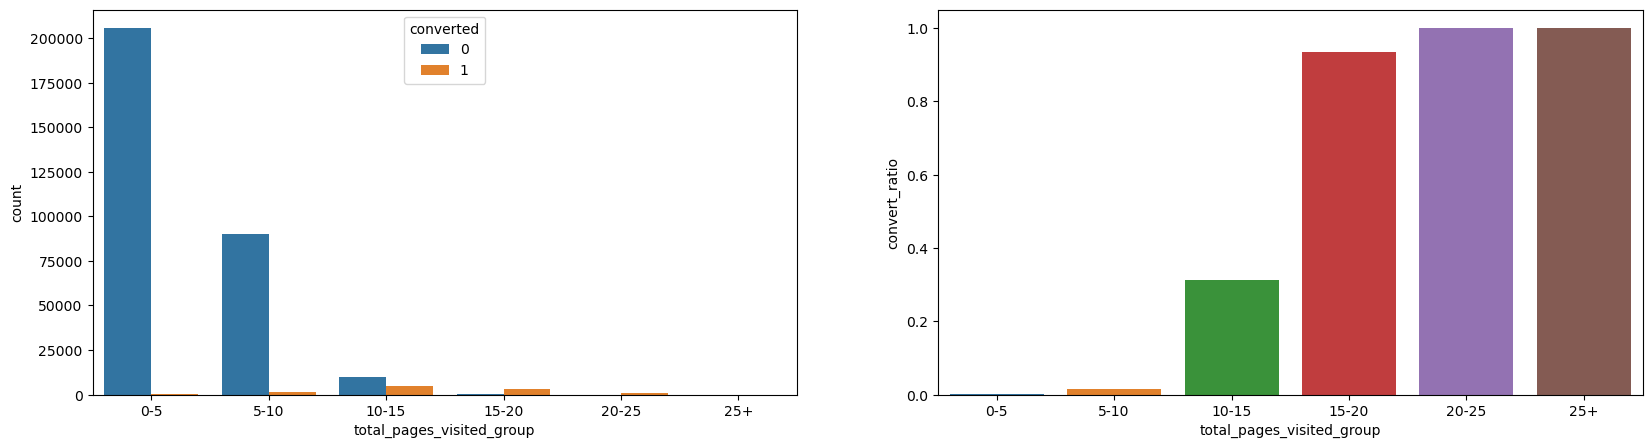

In [303]:
# visits
bins = [0,5, 10, 15, 20, 25, 100]
labels = ['0-5','5-10', '10-15', '15-20','20-25', '25+']
df['total_pages_visited_group'] = pd.cut(df.total_pages_visited, bins, labels = labels)
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20, 5))
sns.countplot(data=df, x="total_pages_visited_group", hue="converted", ax = ax[0])
sns.barplot(data=df.groupby('total_pages_visited_group')['converted'].agg(convert_ratio = 'mean').reset_index(), 
              x="total_pages_visited_group", y="convert_ratio", ax = ax[1])

In [304]:
# Also sort of intuitive, users more likely to be converted are more likely to visit the page
# However, it is worth noting that users visiting 5-10 times (a large group of users), are having a low 
# conversion rate, though visiting 5-10 times should suggest that they are already somewhat intrigued.
# One good next step might be to analyze their road map.

In [305]:
df = df.drop(columns=['age_group', 'total_pages_visited_group'])

# Predict conversion rate


Below we test out XGBoost, Logistic regression, and random forest as a good practice.

Through the practice, I hope to find a best go-to model for take home

PS. You don't need to use every method like I did here, I was just trying to get my hands dirty

## XGBoost

In [318]:
# Chose to use one-hot encoding to show the partial dependence plot later
df_dummy = pd.get_dummies(df, 
                    prefix=['country','source'], 
                    columns = ['country','source'], 
                   )
df_dummy

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
316195,26,1,9,0,0,0,0,1,1,0,0
316196,27,1,6,0,0,0,0,1,0,1,0
316197,25,0,4,0,1,0,0,0,1,0,0
316198,22,0,4,0,0,0,0,1,0,0,1


In [319]:
X = df_dummy.drop(columns=['converted'])
y = df_dummy['converted']

In [320]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [321]:
%%time
# import XGBClassifier
from xgboost import XGBClassifier

# fit model to training data
# using default para
model = XGBClassifier()
model.fit(X_train, y_train)

CPU times: user 23.1 s, sys: 2.73 s, total: 25.9 s
Wall time: 4.72 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [322]:
y_pred = model.predict(X_test)


In [323]:
# check accuracy score
from sklearn.metrics import precision_score, recall_score,f1_score

print('XGBoost model precision_score score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('XGBoost model recall_score score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('XGBoost model f1_score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

XGBoost model precision_score score: 0.8434
XGBoost model recall_score score: 0.6861
XGBoost model f1_score score: 0.7567


In [324]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)
# Highly skewed to the negative class
# F-1 score is a better metric to look at than accuracy
# Precsion and recall are reasonably strong
# hooray, we have a good basline model  
# I am sure we can tune the model to increase the metric here
# BUT, data take homoe is not about that, it's about business impact
# so let's try to have the importance displayed

array([[91462,   384],
       [  946,  2068]])

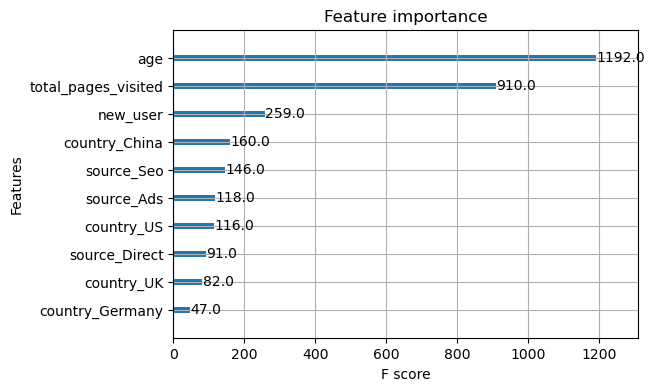

In [325]:
xgb.plot_importance(model,importance_type='weight')
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

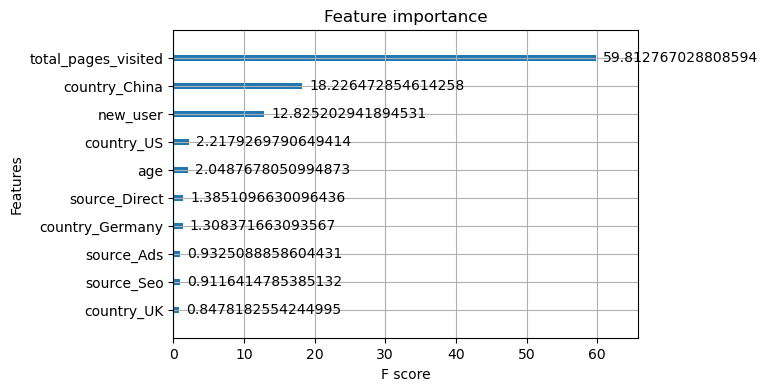

In [326]:
xgb.plot_importance(model,importance_type='gain')
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

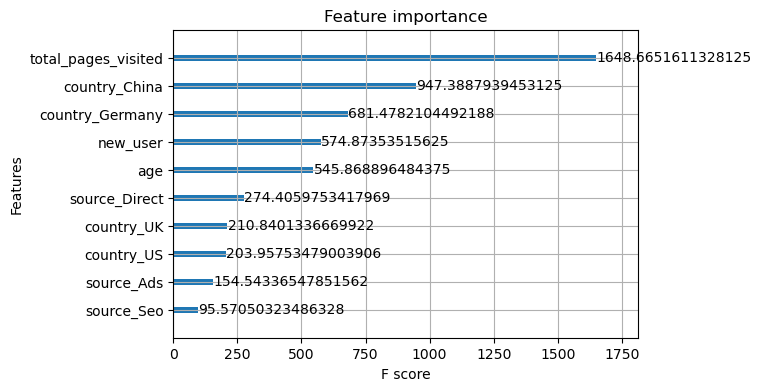

In [327]:
xgb.plot_importance(model,importance_type='cover')
plt.rcParams['figure.figsize'] = [6, 4]
plt.show()

In [328]:
# As we can see, feature importance is actually not consistent using different methods
# of calculating importance
# A more consistent approach is to use SHAP values

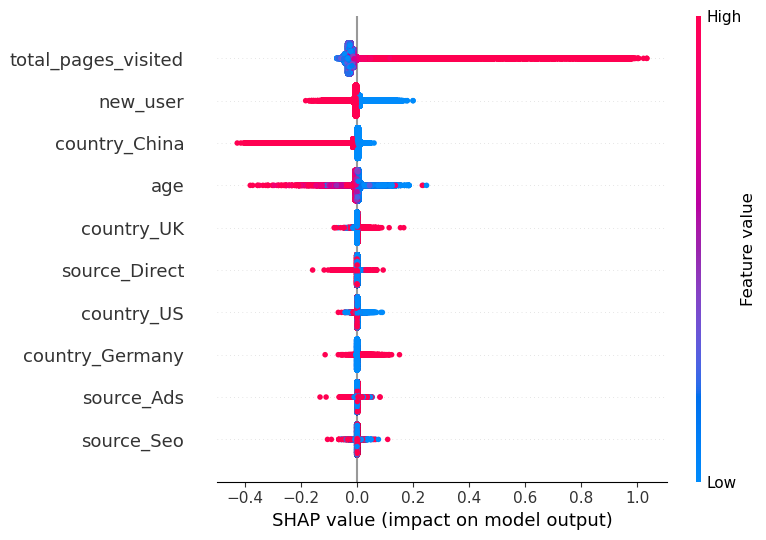

CPU times: user 3min 55s, sys: 4.66 s, total: 4min
Wall time: 47 s


In [329]:
%%time
import xgboost
import shap


model = xgboost.XGBRegressor().fit(X_train, y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)


shap.summary_plot(shap_values, X)

In [330]:
# Basically aligned with EDA

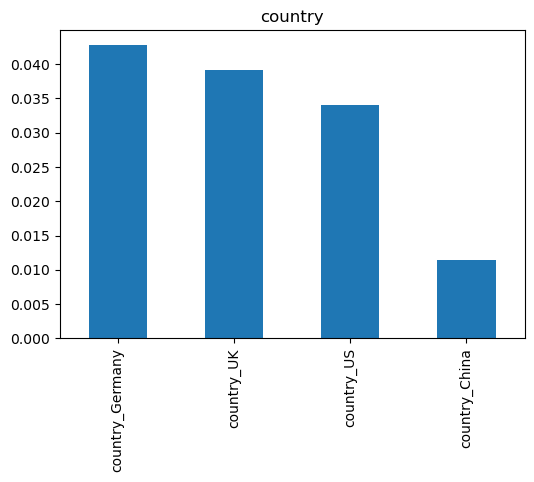

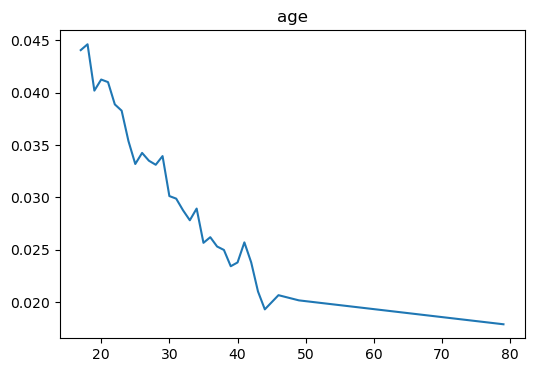

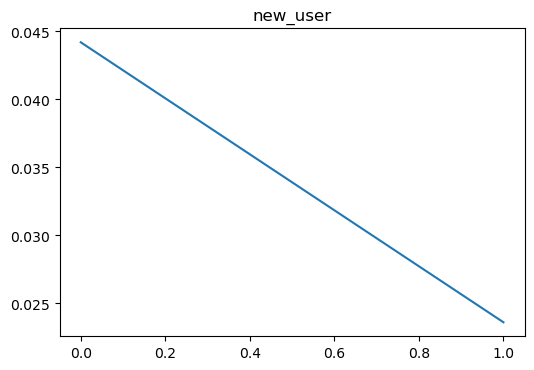

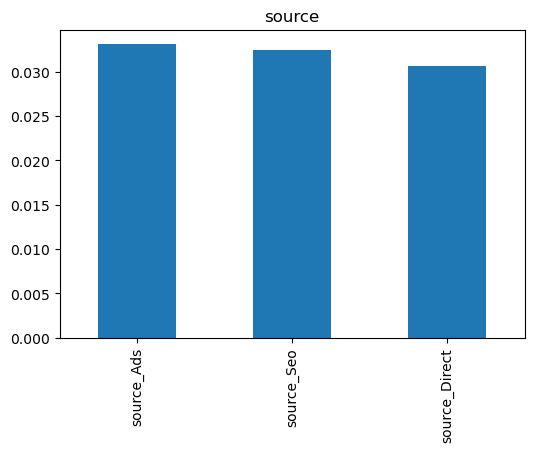

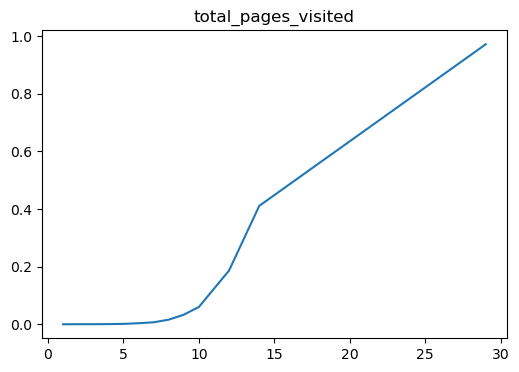

In [331]:
from pdpbox import pdp
# plotting the partial dependence plot to supplement explain 
feat_original = df.columns.drop('converted')

for i in range(len(feat_original)):
    plot_var = [col for col in list(X) if col.startswith(feat_original[i])]
    # this means it is a numerical
    if len(plot_var) ==1:
        pdp_iso = pdp.pdp_isolate(model = model,
                                 dataset= X,
                                 model_features= list(X),
                                 feature= plot_var[0],
                                 num_grid_points = 50)
        pdp_dataset = pd.Series(pdp_iso.pdp, index = pdp_iso.feature_grids)
        pdp_dataset.plot(title=feat_original[i])
        plt.show()
    else:
        pdp_iso = pdp.pdp_isolate(model = model,
                                 dataset= X,
                                 model_features= list(X),
                                 feature= plot_var,
                                 num_grid_points = 50)
        pdp_dataset = pd.Series(pdp_iso.pdp, index = pdp_iso.feature_grids)
        pdp_dataset.sort_values(ascending =False).plot(kind = 'bar',
                                                      title = feat_original[i])
        plt.show()

In [332]:
# The partial dependence plot offers a clearer explanation of the model
# results confirming descriptive analysis earlier

## Logistic regression

In [333]:

# I chose to use both scikit learn and stats model
# let's see which one is more friendly

In [334]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

In [335]:
# check accuracy score
from sklearn.metrics import precision_score, recall_score,f1_score

print('lgr model precision_score score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('lgr model recall_score score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('lgr model f1_score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

lgr model precision_score score: 0.8495
lgr model recall_score score: 0.6818
lgr model f1_score score: 0.7565


In [336]:
from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

array([[91482,   364],
       [  959,  2055]])

In [337]:
# Actually, it is not that different from XGBoost

In [338]:
pd.DataFrame({'coeff': logisticRegr.coef_[0]}, 
             index=X.columns)

,coeff
age,-0.077881
new_user,-1.687891
total_pages_visited,0.758445
country_China,-3.799602
country_Germany,-0.021312
country_UK,-0.224664
country_US,-0.619147
source_Ads,-1.472241
source_Direct,-1.683416
source_Seo,-1.509068


In [339]:
# Stats model
# importing libraries
import statsmodels.api as sm

In [340]:
#add constant to predictor variables
X_cons = sm.add_constant(X_train)

#fit linear regression model
model = sm.Logit(y_train, X_cons).fit()

#view model summary
model.summary()

Optimization terminated successfully.
         Current function value: 0.040577
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               221338
Model:                          Logit   Df Residuals:                   221327
Method:                           MLE   Df Model:                           10
Date:                Tue, 07 Feb 2023   Pseudo R-squ.:                  0.7166
Time:                        19:36:29   Log-Likelihood:                -8981.3
converged:                       True   LL-Null:                       -31692.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.8565   4.73e+05  -1.03e-05      1.000   -9.28e+05    9.28e+05
age                    -0.0771      0.003    -26.984      0.000      -0.083      -0.072
new_user               -1.6873      0.042    -39.890      0.000      -1.770      -1.604
total_pages_visited     0.7606      0.007    102.344      0.000       0.746       0.775
country_China          -3.8526        nan        nan        nan         nan         nan
country_Germany        -0.0690        nan        nan        nan         nan         nan
country_UK             -0.2735        nan        nan        nan         nan         nan
country_US             -0.6614        nan        nan        nan         nan         nan
source_Ads             -1.5355        nan        nan        nan         nan         nan
source_Direct          -1.7513        nan        nan        nan         nan         nan
source_Seo             -1.5697        nan        nan        nan         nan         nan
=======================================================================================

Possibly complete quasi-separation: A fraction 0.32 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [341]:
y_pred = list(map(round, model.predict(sm.add_constant(X_test))))
# check accuracy score


print('lgr_stats_model precision_score score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('lgr_stats_model recall_score score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('lgr_stats_model f1_score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

lgr_stats_model precision_score score: 0.8496
lgr_stats_model recall_score score: 0.6825
lgr_stats_model f1_score score: 0.7569


array([[91482,   364],
       [  957,  2057]])

In [342]:
# Results actually not that different
# stats model seems require more effort
# since you need to add constant, and round the result
# I'd prefer sklearn over it

## Random forest

In [343]:
from sklearn.ensemble import RandomForestClassifier

In [344]:
%%time
random_forest_clf = RandomForestClassifier()
random_forest_clf.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)


CPU times: user 5.88 s, sys: 84.5 ms, total: 5.96 s
Wall time: 6.01 s


In [345]:
print('random_forest precision_score score: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print('random_forest recall_score score: {0:0.4f}'. format(recall_score(y_test, y_pred)))
print('random_forest f1_score score: {0:0.4f}'. format(f1_score(y_test, y_pred)))

from sklearn import metrics
metrics.confusion_matrix(y_test, y_pred)

random_forest precision_score score: 0.8495
random_forest recall_score score: 0.6818
random_forest f1_score score: 0.7565


array([[91482,   364],
       [  959,  2055]])

In [346]:
# Since it's tree model, the feature importance is kinda hard
# to interpret. the result would look similar as the XGBoost, I guess
# the baseline model actually doesn't vary that much

In [347]:
# Summary
# Predict conversion rate: achieved 75% F-1 score in a skewed class, which builds a good benchmark
# if have more time to tune, the results will be better


# Recommendations:
# See Exploratory analysis section

In [348]:
# Reflection

# In data challenge, you don't really need to have the best model. If you have an okay one,
# that's probably enought, let people know that it is improvable, but no need to actully improve it.
# more importantly is to uncover the actions from the data, supported by
# the model.